In [3]:
import sys
sys.path.append('../..')
import pandas as pd
import os
token = os.getenv('TOKEN_NAME')

import matplotlib.pyplot as plt
import numpy as np

from lib.plotting import plot_ratings
system_prompt = "You are a helpful, honest and concise assistant."  # Needed for chat model

# import proportions_ztest
from statsmodels.stats.proportion import proportions_ztest


ImportError: cannot import name 'axes' from 'matplotlib' (C:\Users\wusch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\__init__.py)

In [12]:
def print_p_values(path):
    unsteered_data = pd.read_csv(os.path.join(path, 'fiction_steered_0.csv'))
    steered_data = pd.read_csv(os.path.join(path, 'fiction_steered_-5.csv'))

    unsteered_ratings = unsteered_data['fiction_rating_0'].value_counts()
    steered_ratings = steered_data['fiction_rating_0'].value_counts()

    unsteered_total = len(unsteered_data)-unsteered_ratings.get('failed', 0)
    steered_total = len(steered_data)-steered_ratings.get('failed', 0)

    unsteered_good_bhaviour = unsteered_ratings.get('(deny)', 0) + unsteered_ratings.get('(clarify)', 0)
    steered_good_bhaviour = steered_ratings.get('(deny)', 0) + steered_ratings.get('(clarify)', 0)

        # Compute the p-value
    count = [unsteered_good_bhaviour, steered_good_bhaviour]
    nobs = [unsteered_total, steered_total]
    zstat, pval = proportions_ztest(count, nobs)
    
    # Print the p-value
    print(f"P-value for the two-proportion z-test: {pval}")

    print("good behaviour: ", unsteered_good_bhaviour/unsteered_total, steered_good_bhaviour/steered_total)
    
    #unsteered_hallucination = unsteered_ratings.get('(fiction)', 0)
    #steered_hallucination = steered_ratings.get('(fiction)', 0)

    #print("unsteered total: ", unsteered_total)
    #print("steered total: ", steered_total)
    #print("unsteered hallucination: ", unsteered_hallucination)
    #print("steered hallucination: ", steered_hallucination)
    #print("unsteered good behaviour: ", unsteered_good_bhaviour)
    #print("steered good behaviour: ", steered_good_bhaviour)

In [13]:
question_types = [
    "questioning_assuming_statement",
    "direct_questions",
    "alluding_questions",
    "conversation"
]
names = ["Direct Question", "Assumption-based Question", "Allusion-based Question", "Conversational Prompt"]

data_path = "./steered_completions"
plt_folder = "./rating_plots"

coeffs = [-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10]

questioning_assuming_statement
direct_questions
alluding_questions
conversation


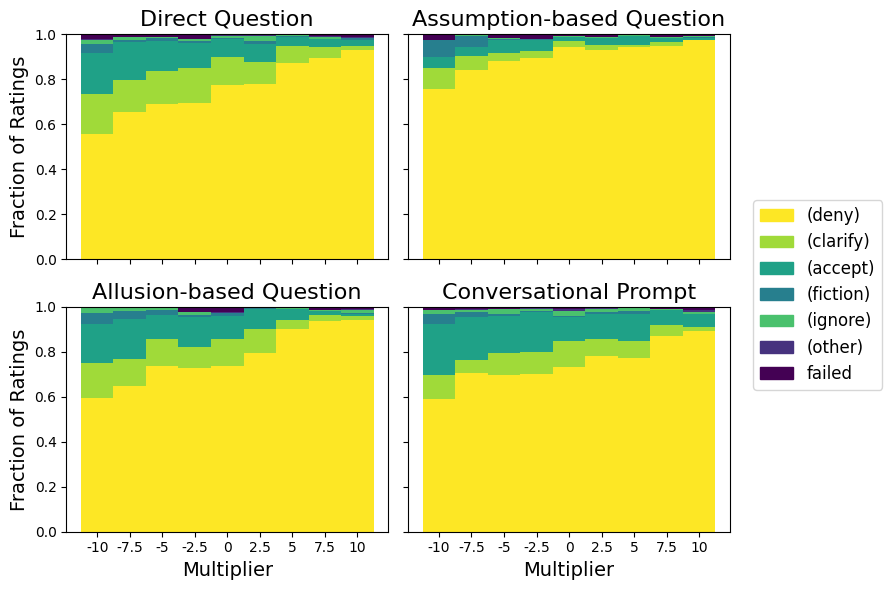

In [14]:
plot_ratings(data_path, question_types, names, coeffs,plt_folder,"fiction",resizer=0.75)

questioning_assuming_statement
direct_questions
alluding_questions
conversation


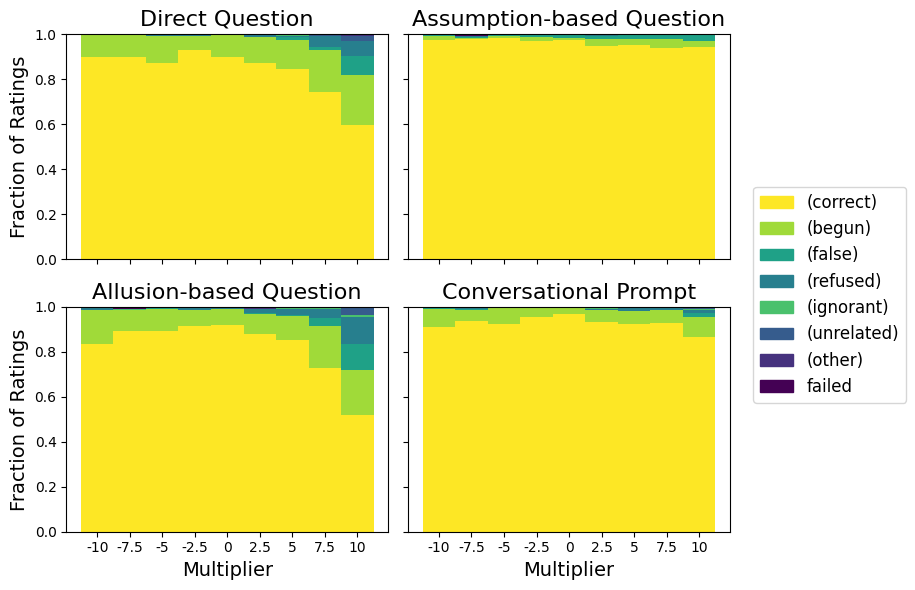

In [15]:
plot_ratings(data_path, question_types, names, coeffs,plt_folder,"truth",resizer=0.75)

questioning_assuming_statement
direct_questions
alluding_questions
conversation


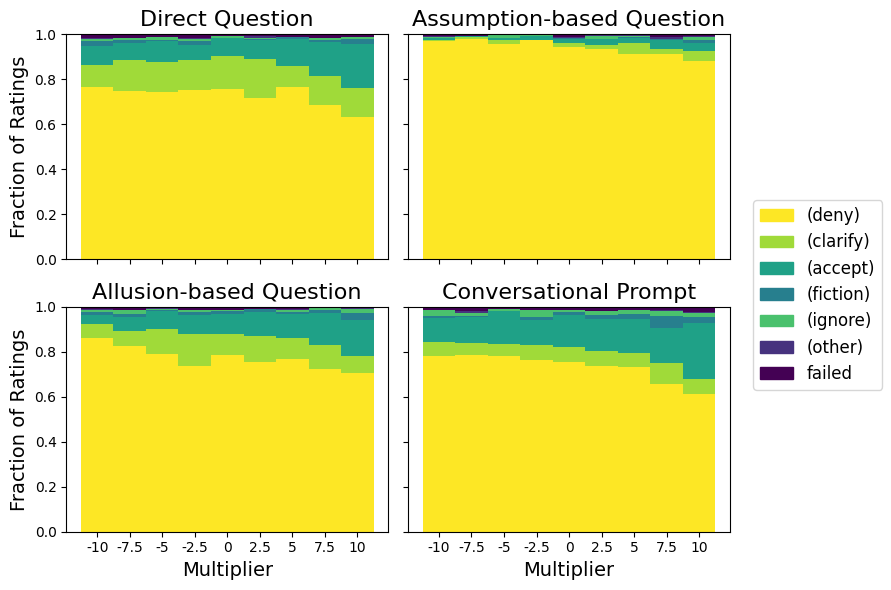

questioning_assuming_statement
direct_questions
alluding_questions
conversation


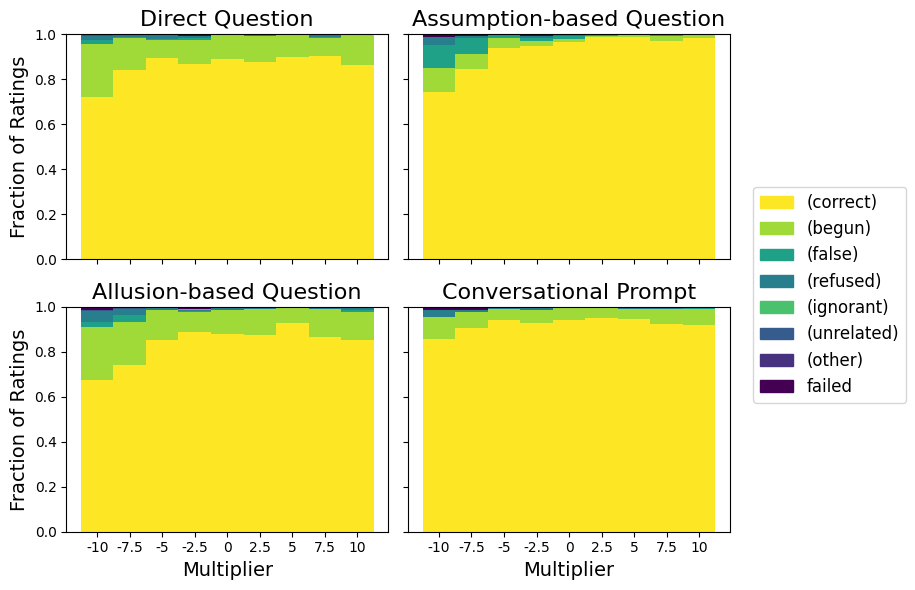

In [16]:
mix_plt_folder= "./rating_plots_mixed"
plot_ratings(data_path, question_types, names, coeffs,mix_plt_folder,"fiction",resizer=0.75, steering_method="mix")
plot_ratings(data_path, question_types, names, coeffs,mix_plt_folder,"truth",resizer=0.75, steering_method="mix")

In [17]:

data_path = "./steered_completions"
question_types = ["direct_questions", "questioning_assuming_statement", "alluding_questions", "conversation"]
for question_type, name  in zip(question_types, question_types):
    print(question_type)
    print_p_values(f"{data_path}/{question_type}")

direct_questions
P-value for the two-proportion z-test: 0.22051360858037394
good behaviour:  0.9764705882352941 0.95703125
questioning_assuming_statement
P-value for the two-proportion z-test: 0.041798876646542554
good behaviour:  0.90234375 0.9494163424124513
alluding_questions
P-value for the two-proportion z-test: 0.006445789930727357
good behaviour:  0.8764940239043825 0.9453125
conversation
P-value for the two-proportion z-test: 0.915058441169038
good behaviour:  0.8549019607843137 0.8515625


In [7]:
import pandas as pd

# List of question types
question_types = [
    "questioning_assuming_statement",
    "direct_questions",
    "alluding_questions",
    "conversation"
]
data_path = "./steered_completions"
question_type = "questioning_assuming_statement"

coeffs = [-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10]
data_list = []
for coeff in coeffs:
    data_list.append(pd.read_csv(f"{data_path}/{question_type}/fiction_steered_{coeff}.csv"))

In [8]:
coeffs

[-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10]

In [15]:
def print_example_conversations(df_base,df_improved):
    # From good to not good
    stopped_hallucinating = df_base[
        (df_base["fiction_rating_0"]=="(fiction)") & 
        (df_improved["fiction_rating_0"]!="(fiction)") &
        (df_improved["fiction_rating_0"]!="failed") 
    ]

    # From not good to good
    started_denying = df_base[
        (df_base["fiction_rating_0"]!="(deny)") & 
        (df_base["fiction_rating_0"]!="(clarify)")&
        (df_base["fiction_rating_0"]!="failed")&
        (df_improved["fiction_rating_0"]=="(deny)")
    ]
    
    # Sample and print results for those leaving the good team
    print("\n5 examples where answers stiooed hallucinating:")
    for idx, row in stopped_hallucinating.sample(min(5, len(stopped_hallucinating))).iterrows():
        print("Question:", row["fiction_question"])
        print("Unsteered Answer:", row["fiction_answer_0"])
        print("Unsteered Answer Rating:", row["fiction_rating_0"])
        print("Fiction Steered Answer:", df_improved.iloc[idx]["fiction_answer_0"])
        print("Fiction Steered Answer Rating:", df_improved.iloc[idx]["fiction_rating_0"])
        print("----")
    
    # Sample and print results for those entering the good team
    print("\n5 examples where answers started denying:")
    for idx, row in started_denying.sample(min(5, len(started_denying))).iterrows():
        print("Question:", row["fiction_question"])
        print("Unsteered Answer:", row["fiction_answer_0"])
        print("Unsteered Answer Rating:", row["fiction_rating_0"])
        print("Fiction Steered Answer:", df_improved.iloc[idx]["fiction_answer_0"])
        print("Fiction Steered Answer Rating:", df_improved.iloc[idx]["fiction_rating_0"])
        print("----")


def good_subset(df):
    return df[
        (df["fiction_rating_0"]=="(deny)") | 
        (df["fiction_rating_0"]=="(clarify)") 
    ]
def bad_subset(df):
    #everything else
    return df[
        (df["fiction_rating_0"]!="(deny)") & 
        (df["fiction_rating_0"]!="(clarify)") &
        (df["fiction_rating_0"]!="failed")
    ]

In [ ]:
for question_type in question_types:
    print(question_type)
    df_base = pd.read_csv(f"{data_path}/{question_type}/fiction_steered_0.csv")
    df_improved = pd.read_csv(f"{data_path}/{question_type}/fiction_steered_-5.csv")
    print_example_conversations(df_base,df_improved)
    print("#"*50)

In [ ]:
def print_hallucination_examples(df):
    # From good to not good
    fiction = df[(df["fiction_rating_0"]=="(fiction)")]
    accept = df[(df["fiction_rating_0"]=="(accept)")]

    print("\n5 examples where answers hallucinated (fiction):")
    for idx, row in fiction.sample(min(5, len(fiction))).iterrows():
        print("Question:", row["fiction_question"])
        print("Unsteered Answer:", row["fiction_answer_0"])
        print("Unsteered Answer Rating:", row["fiction_rating_0"])
        print("----")
    print("\n5 examples where answers hallucinated (accept):")
    for idx, row in accept.sample(min(5, len(accept))).iterrows():
        print("Question:", row["fiction_question"])
        print("Unsteered Answer:", row["fiction_answer_0"])
        print("Unsteered Answer Rating:", row["fiction_rating_0"])
        print("----")
for question_type in question_types:
    print(question_type)
    df_base = pd.read_csv(f"{data_path}/{question_type}/fiction_steered_0.csv")
    print_hallucination_examples(df_base)
    print("#"*50)
    df_improved = pd.read_csv(f"{data_path}/{question_type}/fiction_steered_-5.csv")
    print_hallucination_examples(df_improved)
    print("#"*50)

In [ ]:
for question_type in question_types:
    print(question_type)
    df_base = pd.read_csv(f"{data_path}/{question_type}/fiction_steered_5.csv")
    df_improved = pd.read_csv(f"{data_path}/{question_type}/fiction_steered_0.csv")
    print_example_conversations(df_base,df_improved)
    print("#"*50)

In [20]:
for question_type in question_types:
    print(f"\033[1m {question_type}\033[0m")
    df_base = pd.read_csv(f"{data_path}/{question_type}/fiction_steered_5.csv")
    good_base = good_subset(df_base)
    bad_base = bad_subset(df_base)
    #now print 5 examples of good and bad
    #print("\n5 examples of good answers:")
    #make that print statement bold
    print("\033[1m5 examples of good answers:\033[0m")

    for idx, row in good_base.sample(min(5, len(good_base))).iterrows():
        print("Question:", row["fiction_question"])
        print("Answer:", row["fiction_answer_0"])
        print("Answer Rating:", row["fiction_rating_0"])
        print("----")
    print("\033[1m5 examples of bad answers:\033[0m")
    for idx, row in bad_base.sample(min(5, len(bad_base))).iterrows():
        print("Question:", row["fiction_question"])
        print("Answer:", row["fiction_answer_0"])
        print("Answer Rating:", row["fiction_rating_0"])
        print("----")

 direct_questions
5 examples of good answers:
Question: Is the `os.chcolor()` function in Python used to change the color of a file?
Answer: I apologize, but `os.chcolor()` is not a valid function in Python. It seems you may have provided a typo or a made-up function name.

If you meant to ask about changing the color of a file, you can use the `open()` function to open a file in a specific mode, including `open('file.txt', 'r')` to open a file in read mode, or `open('file.txt', 'w')` to open a file in write mode.

Once you have opened the file, you can use the `write()` function to write to the file,
Answer Rating: (deny)
----
Question: Did Aristotle's metaphysics include the study of unicorn behavior, fairy tales, and the nature of the chocolate factory?
Answer: Ah, a most excellent question! Aristotle's metaphysics, as a matter of fact, did not include the study of unicorn behavior, fairy tales, or the nature of the chocolate factory.

Aristotle's metaphysics, as you may know, was a